# MNIST ConvNet Exploration
Goal: Explore different cnn architectures, try to break 99.8% test accuracy
Architectures:
- CNN 3x3x[1,3,5,7] -> Relu -> Maxpool -> Dense -> Output Layer -> Softmax -> Y
- CNN 3x3x[1,3,5,7] -> Relu -> Maxpool -> CNN 3x3x[1,3,5,7] -> Relu -> Maxpool -> Dense -> Output Layer -> Softmax -> Y
- CNN 3x3x[1,3,5,7] -> Relu -> Maxpool -> CNN 3x3x[1,3,5,7] -> Relu -> Maxpool -> Dense -> Output Layer -> Softmax -> Y\


In [1]:
# load libraries
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import math

/usr/local/envs/jupyterlab/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
training label shape:  (55000, 10)
training input shape:  (55000, 784)
test label shape:  (10000, 10)
test input shape:  (10000, 784)
number of training examples:  55000
number of classes:  10
number of input:  784


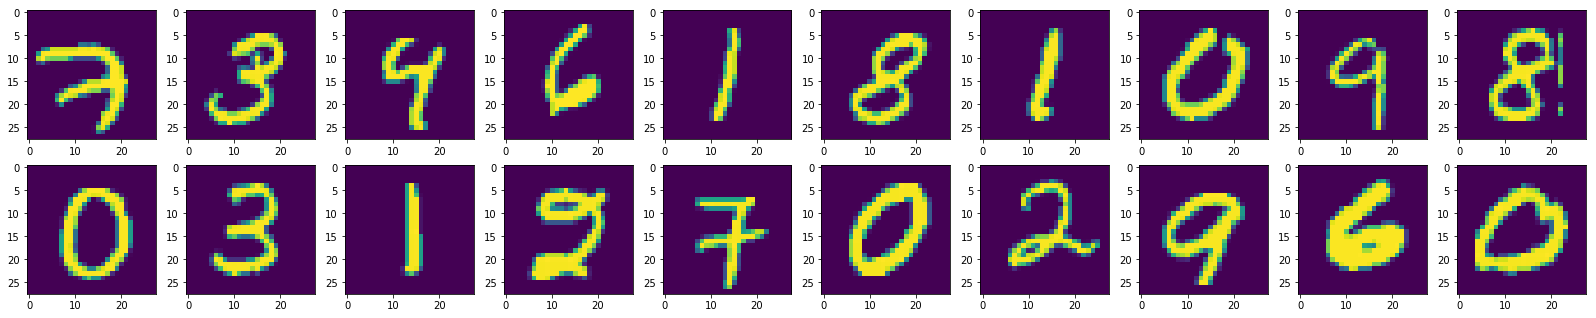

In [20]:
# import mnist dataset
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True)

n_train_examples = mnist.train.labels.shape[0]
n_test_examples = mnist.test.labels.shape[0]
n_Y = mnist.train.labels.shape[1]
n_X = mnist.train.images.shape[1]

# exploration around shapes and dimensions
print("training label shape: ", mnist.train.labels.shape)
print("training input shape: ", mnist.train.images.shape)
print("test label shape: ", mnist.test.labels.shape)
print("test input shape: ", mnist.test.images.shape)
print("number of training examples: ", n_train_examples)
print("number of classes: ", n_Y)
print("number of input: ", n_X)

image_width = 28
image_height = 28

def plot_images(images, w, h):
    """Plots array of image vectors into grid using matplotlib.
    
    Args:
        images: [n, 784] - array of flattened image vectors
        w: int - width of reshaped image
        h: int - height of reshaped image
    
    Returns:
        plot of images filled into 10 x 10 grids
    """
    reshaped_images = [ np.reshape(image, (w, h)) * 255 for image in images ]
    fig = plt.figure(figsize=(w, h))
    for i in range(len(reshaped_images)):
        fig.add_subplot(10,10,i + 1)
        plt.imshow(reshaped_images[i])
    plt.show()

def xavier_initializer(shape):
    """Initializes tensor with random values normalized by square root of 1/n_input, 
    should help keep control exploding/vanishing gradients for sigmoid activations
    http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    
    Args:
        shape: [int,int] - size of input and output tensor
    
    Returns:
        returns tensor of size shape 
    """
    return tf.random_normal(shape) * math.sqrt(1.0/shape[0])

def relu_initializer(shape):
    """Initializes tensor with random values normalized by square root of 2/n_input, 
    should help keep control exploding/vanishing gradients for relu activation
    https://arxiv.org/pdf/1502.01852.pdf
    
    Args:
        shape: [int,int] - size of input and output tensor
    
    Returns:
        returns tensor of size shape
    """
    return tf.random_normal(shape) * math.sqrt(1.0/shape[0])

def train(model, optimizer, epochs=10, batch_size=64, print_progress=True):
    """trains model using specified optimizer and returns as dictionary of results
    
    Args:
        model: tf graph - tf graph to train
        optimizer: tf optimizer - optimizer to use during training
        epochs: int - number of training epochs to perform
        batch_size: int - batch_size to use during training
        print_progress: boolean - flag to print progress during training
    
    Returns:
        returns dictionary  {
            'summaries': array of dictionary results,
            'model': tf model graph useful for inference or further examination
        }
    """
    Y = tf.placeholder(tf.float32, shape=[None, n_Y])
    
    # Define loss graph
    loss_graph = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y))
    training_graph = optimizer.minimize(loss_graph)

    # Define accuracy
    correct_predictions = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
    accuracy_graph = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    summaries = []
    with tf.device('/gpu:0'):
        with tf.Session() as session:

            # initialize inputs
            session.run(tf.global_variables_initializer())

            # run optimization
            for epoch in range(epochs):
                # train through each batch
                batch_count = int(mnist.train.num_examples/batch_size)
                batch_loss_results = []
                batch_accuracy_results = []
                for batch in range(batch_count):
                    batch_x, batch_y = mnist.train.next_batch(batch_size)
                    session.run(training_graph, feed_dict={X: batch_x, Y: batch_y})
                    batch_loss, batch_accuracy = session.run([loss_graph, accuracy_graph], feed_dict={X: batch_x, Y: batch_y})
                    batch_loss_results.append(batch_loss)
                    batch_accuracy_results.append(batch_accuracy)
                    
                train_loss, train_accuracy = [np.mean(batch_loss_results), np.mean(batch_accuracy_results)]
                test_loss, test_accuracy = session.run([loss_graph, accuracy_graph], feed_dict={X: mnist.test.images, Y: mnist.test.labels})
                summary = {
                    'epoch': epoch,
                    'batch': batch, 
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'test_loss': test_loss,
                    'test_accuracy': test_accuracy
                }
                summaries.append(summary)
                if print_progress:
                    print("Epoch:", epoch, 
                          "Batch:", batch, 
                          "Training Loss:", train_loss, 
                          "Training Accuracy:", train_accuracy, 
                          "Test Loss:", test_loss, 
                          "Test Accuracy:", test_accuracy)
    
    return {
        'summaries': summaries,
        'model': model
    }

def plot_summaries(summaries):
    """plots loss during training 
    
    Args:
        summaries: array of dictionaries
    
    Returns:
        returns matplotlib of training losses
    """
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    for i in range(len(summaries)):
        plt.plot(i, summaries[i]['train_loss'], 'b+', label='training loss')
        plt.plot(i, summaries[i]['test_loss'], 'r+', label='test loss')
    plt.xlabel('epochs')
    plt.ylabel('cross entropy loss')
#     for i in range(len(summaries)):
    plt.subplot(2,1,2)
    for i in range(len(summaries)):
        plt.plot(i, summaries[i]['train_accuracy'], 'b+', label='train accuracy')
        plt.plot(i, summaries[i]['test_accuracy'], 'r+', label='test accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

# sample training images
plot_images(mnist.train.images[0:20], image_width, image_height)

parameters:  {'conv_1_kernel_size': 3, 'conv_1_filters': 32}
Epoch: 0 Batch: 106 Training Loss: 0.1834206 Training Accuracy: 0.94721085 Test Loss: 0.07297241 Test Accuracy: 0.9776
Epoch: 1 Batch: 106 Training Loss: 0.043850254 Training Accuracy: 0.9878249 Test Loss: 0.045582134 Test Accuracy: 0.9853
Epoch: 2 Batch: 106 Training Loss: 0.0241135 Training Accuracy: 0.9936843 Test Loss: 0.03590519 Test Accuracy: 0.9881
Epoch: 3 Batch: 106 Training Loss: 0.012737745 Training Accuracy: 0.9972985 Test Loss: 0.035733882 Test Accuracy: 0.9881
Epoch: 4 Batch: 106 Training Loss: 0.008914111 Training Accuracy: 0.99810165 Test Loss: 0.03675209 Test Accuracy: 0.9874
Epoch: 5 Batch: 106 Training Loss: 0.00406178 Training Accuracy: 0.9995254 Test Loss: 0.037872553 Test Accuracy: 0.9888
Epoch: 6 Batch: 106 Training Loss: 0.0033488234 Training Accuracy: 0.99970794 Test Loss: 0.037982352 Test Accuracy: 0.9892
Epoch: 7 Batch: 106 Training Loss: 0.0023627738 Training Accuracy: 0.9997627 Test Loss: 0.034865

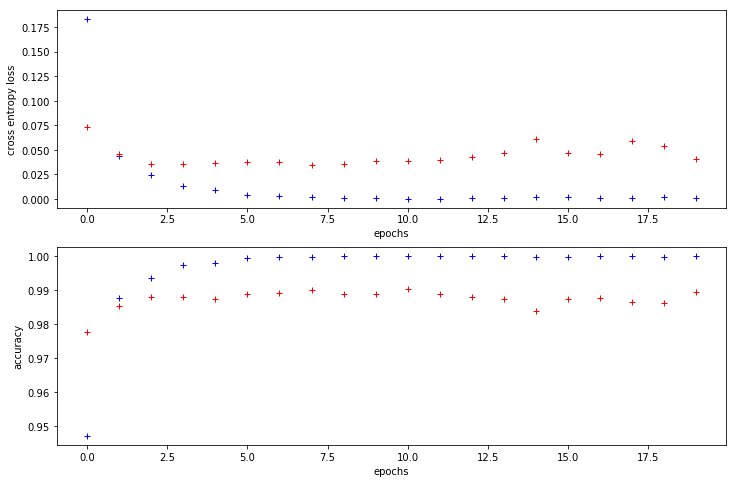

parameters:  {'conv_1_kernel_size': 3, 'conv_1_filters': 4}
Epoch: 0 Batch: 106 Training Loss: 0.41068935 Training Accuracy: 0.8937646 Test Loss: 0.20466846 Test Accuracy: 0.9392
Epoch: 1 Batch: 106 Training Loss: 0.15898396 Training Accuracy: 0.9542385 Test Loss: 0.12298679 Test Accuracy: 0.9635
Epoch: 2 Batch: 106 Training Loss: 0.10275968 Training Accuracy: 0.97090393 Test Loss: 0.1028604 Test Accuracy: 0.9668
Epoch: 3 Batch: 106 Training Loss: 0.07888638 Training Accuracy: 0.9774934 Test Loss: 0.07562141 Test Accuracy: 0.9758
Epoch: 4 Batch: 106 Training Loss: 0.05729512 Training Accuracy: 0.98364484 Test Loss: 0.06577947 Test Accuracy: 0.9793
Epoch: 5 Batch: 106 Training Loss: 0.048733234 Training Accuracy: 0.9860543 Test Loss: 0.06344235 Test Accuracy: 0.9803
Epoch: 6 Batch: 106 Training Loss: 0.039459337 Training Accuracy: 0.9890114 Test Loss: 0.06347808 Test Accuracy: 0.9794
Epoch: 7 Batch: 106 Training Loss: 0.03346555 Training Accuracy: 0.9908915 Test Loss: 0.059562206 Test A

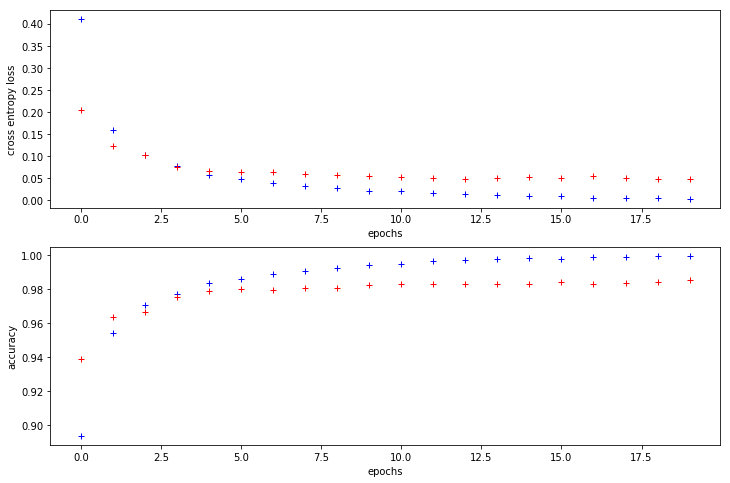

parameters:  {'conv_1_kernel_size': 3, 'conv_1_filters': 8}
Epoch: 0 Batch: 106 Training Loss: 0.29988462 Training Accuracy: 0.91796875 Test Loss: 0.14050789 Test Accuracy: 0.9593
Epoch: 1 Batch: 106 Training Loss: 0.10619369 Training Accuracy: 0.9695714 Test Loss: 0.0906069 Test Accuracy: 0.9722
Epoch: 2 Batch: 106 Training Loss: 0.06512451 Training Accuracy: 0.9817465 Test Loss: 0.06993754 Test Accuracy: 0.9772
Epoch: 3 Batch: 106 Training Loss: 0.044192478 Training Accuracy: 0.9880622 Test Loss: 0.051154558 Test Accuracy: 0.9839
Epoch: 4 Batch: 106 Training Loss: 0.03258867 Training Accuracy: 0.9908915 Test Loss: 0.051642165 Test Accuracy: 0.9826
Epoch: 5 Batch: 106 Training Loss: 0.02412101 Training Accuracy: 0.9939216 Test Loss: 0.045233086 Test Accuracy: 0.9843
Epoch: 6 Batch: 106 Training Loss: 0.01828501 Training Accuracy: 0.99565566 Test Loss: 0.046450183 Test Accuracy: 0.9831
Epoch: 7 Batch: 106 Training Loss: 0.013806628 Training Accuracy: 0.99715245 Test Loss: 0.049020022 T

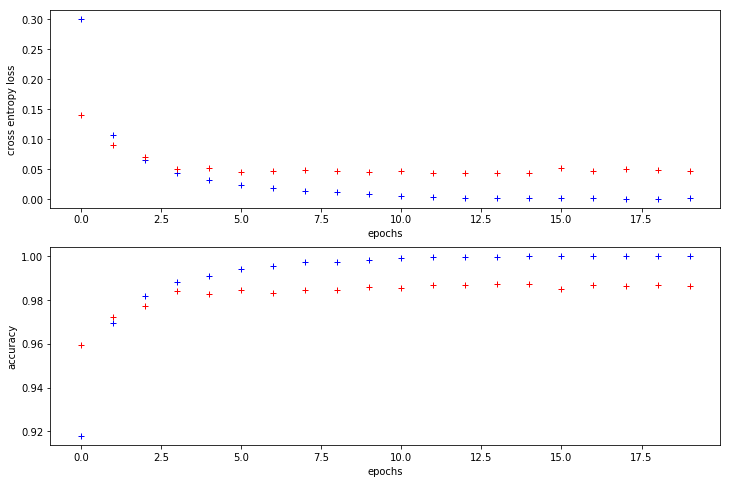

parameters:  {'conv_1_kernel_size': 3, 'conv_1_filters': 16}
Epoch: 0 Batch: 106 Training Loss: 0.23228666 Training Accuracy: 0.93441516 Test Loss: 0.10586892 Test Accuracy: 0.9675
Epoch: 1 Batch: 106 Training Loss: 0.07241247 Training Accuracy: 0.9795561 Test Loss: 0.062072862 Test Accuracy: 0.9796
Epoch: 2 Batch: 106 Training Loss: 0.041224614 Training Accuracy: 0.98835427 Test Loss: 0.054884154 Test Accuracy: 0.982
Epoch: 3 Batch: 106 Training Loss: 0.02767089 Training Accuracy: 0.99253434 Test Loss: 0.042555146 Test Accuracy: 0.9857
Epoch: 4 Batch: 106 Training Loss: 0.018874716 Training Accuracy: 0.9953271 Test Loss: 0.046171587 Test Accuracy: 0.9854
Epoch: 5 Batch: 106 Training Loss: 0.0120215025 Training Accuracy: 0.9974445 Test Loss: 0.041498892 Test Accuracy: 0.9855
Epoch: 6 Batch: 106 Training Loss: 0.008375876 Training Accuracy: 0.99853975 Test Loss: 0.04132409 Test Accuracy: 0.9859
Epoch: 7 Batch: 106 Training Loss: 0.0061950884 Training Accuracy: 0.9991421 Test Loss: 0.041

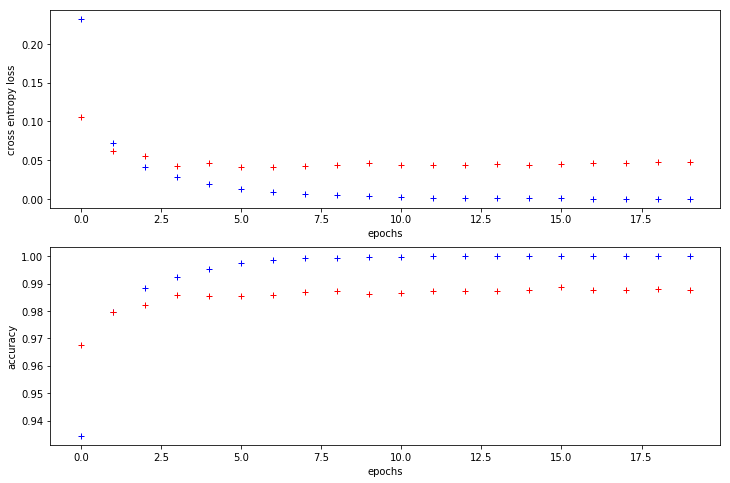

parameters:  {'conv_1_kernel_size': 5, 'conv_1_filters': 32}
Epoch: 0 Batch: 106 Training Loss: 0.16778156 Training Accuracy: 0.95046 Test Loss: 0.060123146 Test Accuracy: 0.9809
Epoch: 1 Batch: 106 Training Loss: 0.041147888 Training Accuracy: 0.9883177 Test Loss: 0.046677116 Test Accuracy: 0.9851
Epoch: 2 Batch: 106 Training Loss: 0.022673117 Training Accuracy: 0.9938303 Test Loss: 0.041406497 Test Accuracy: 0.9858
Epoch: 3 Batch: 106 Training Loss: 0.01311716 Training Accuracy: 0.99695164 Test Loss: 0.033102974 Test Accuracy: 0.9885
Epoch: 4 Batch: 106 Training Loss: 0.007725836 Training Accuracy: 0.99844843 Test Loss: 0.04168883 Test Accuracy: 0.9875
Epoch: 5 Batch: 106 Training Loss: 0.005122253 Training Accuracy: 0.9991421 Test Loss: 0.03380521 Test Accuracy: 0.9892
Epoch: 6 Batch: 106 Training Loss: 0.0026422571 Training Accuracy: 0.9997262 Test Loss: 0.03633483 Test Accuracy: 0.9892
Epoch: 7 Batch: 106 Training Loss: 0.0016246212 Training Accuracy: 0.99978095 Test Loss: 0.04106

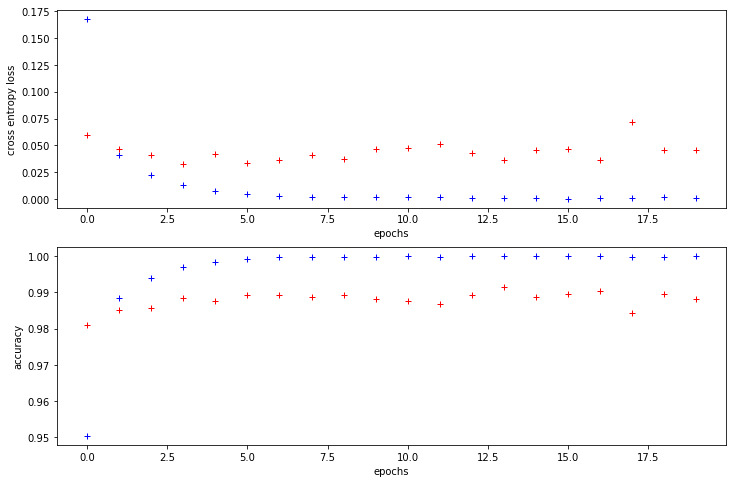

parameters:  {'conv_1_kernel_size': 5, 'conv_1_filters': 4}
Epoch: 0 Batch: 106 Training Loss: 0.36337715 Training Accuracy: 0.9097547 Test Loss: 0.1526288 Test Accuracy: 0.9551
Epoch: 1 Batch: 106 Training Loss: 0.11677253 Training Accuracy: 0.9668699 Test Loss: 0.098806635 Test Accuracy: 0.9699
Epoch: 2 Batch: 106 Training Loss: 0.07647211 Training Accuracy: 0.9781323 Test Loss: 0.074137464 Test Accuracy: 0.9773
Epoch: 3 Batch: 106 Training Loss: 0.059840783 Training Accuracy: 0.9825131 Test Loss: 0.061481703 Test Accuracy: 0.9808
Epoch: 4 Batch: 106 Training Loss: 0.045331564 Training Accuracy: 0.98702174 Test Loss: 0.054819964 Test Accuracy: 0.9828
Epoch: 5 Batch: 106 Training Loss: 0.037484292 Training Accuracy: 0.9891757 Test Loss: 0.050382927 Test Accuracy: 0.984
Epoch: 6 Batch: 106 Training Loss: 0.03135732 Training Accuracy: 0.99072725 Test Loss: 0.048596147 Test Accuracy: 0.9834
Epoch: 7 Batch: 106 Training Loss: 0.025989193 Training Accuracy: 0.9927534 Test Loss: 0.04795529 

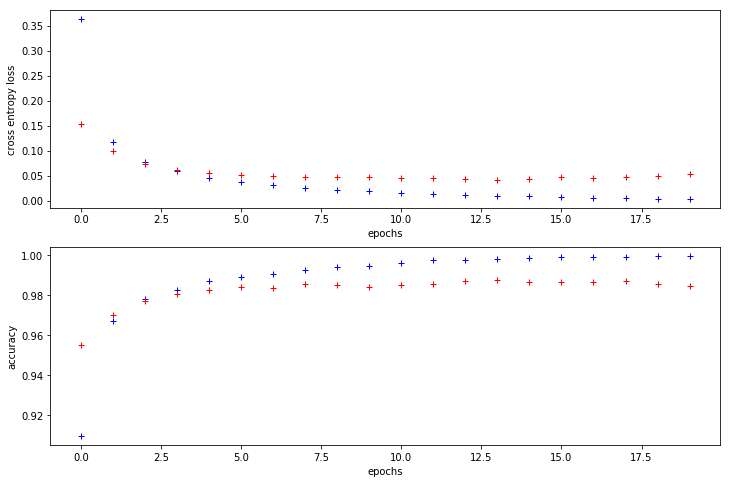

parameters:  {'conv_1_kernel_size': 5, 'conv_1_filters': 8}
Epoch: 0 Batch: 106 Training Loss: 0.3000221 Training Accuracy: 0.92158294 Test Loss: 0.10962155 Test Accuracy: 0.9684
Epoch: 1 Batch: 106 Training Loss: 0.08212366 Training Accuracy: 0.97654426 Test Loss: 0.07050657 Test Accuracy: 0.9797
Epoch: 2 Batch: 106 Training Loss: 0.052944925 Training Accuracy: 0.9846853 Test Loss: 0.050102726 Test Accuracy: 0.9837
Epoch: 3 Batch: 106 Training Loss: 0.038541954 Training Accuracy: 0.9886828 Test Loss: 0.046588477 Test Accuracy: 0.984
Epoch: 4 Batch: 106 Training Loss: 0.028920943 Training Accuracy: 0.9921145 Test Loss: 0.042235725 Test Accuracy: 0.9869
Epoch: 5 Batch: 106 Training Loss: 0.02270927 Training Accuracy: 0.9936843 Test Loss: 0.049750924 Test Accuracy: 0.984
Epoch: 6 Batch: 106 Training Loss: 0.016925644 Training Accuracy: 0.996039 Test Loss: 0.039232872 Test Accuracy: 0.9876
Epoch: 7 Batch: 106 Training Loss: 0.014416134 Training Accuracy: 0.9963676 Test Loss: 0.045125306 T

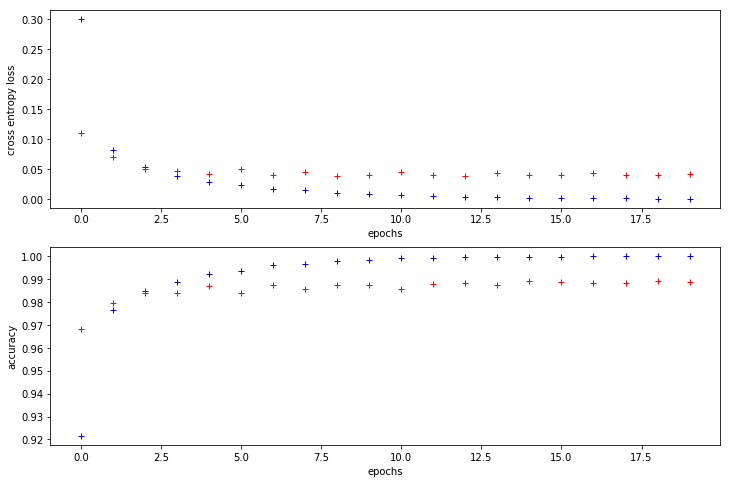

parameters:  {'conv_1_kernel_size': 5, 'conv_1_filters': 16}
Epoch: 0 Batch: 106 Training Loss: 0.21575454 Training Accuracy: 0.9377008 Test Loss: 0.08053299 Test Accuracy: 0.9758
Epoch: 1 Batch: 106 Training Loss: 0.056371152 Training Accuracy: 0.9843202 Test Loss: 0.05204403 Test Accuracy: 0.9832
Epoch: 2 Batch: 106 Training Loss: 0.035477083 Training Accuracy: 0.9899971 Test Loss: 0.045066852 Test Accuracy: 0.9854
Epoch: 3 Batch: 106 Training Loss: 0.024608746 Training Accuracy: 0.99322796 Test Loss: 0.042029414 Test Accuracy: 0.9865
Epoch: 4 Batch: 106 Training Loss: 0.01607444 Training Accuracy: 0.9958017 Test Loss: 0.03530559 Test Accuracy: 0.9885
Epoch: 5 Batch: 106 Training Loss: 0.010724788 Training Accuracy: 0.99759054 Test Loss: 0.043248087 Test Accuracy: 0.9876
Epoch: 6 Batch: 106 Training Loss: 0.00869803 Training Accuracy: 0.99821115 Test Loss: 0.037556976 Test Accuracy: 0.9874
Epoch: 7 Batch: 106 Training Loss: 0.005956113 Training Accuracy: 0.9990508 Test Loss: 0.035839

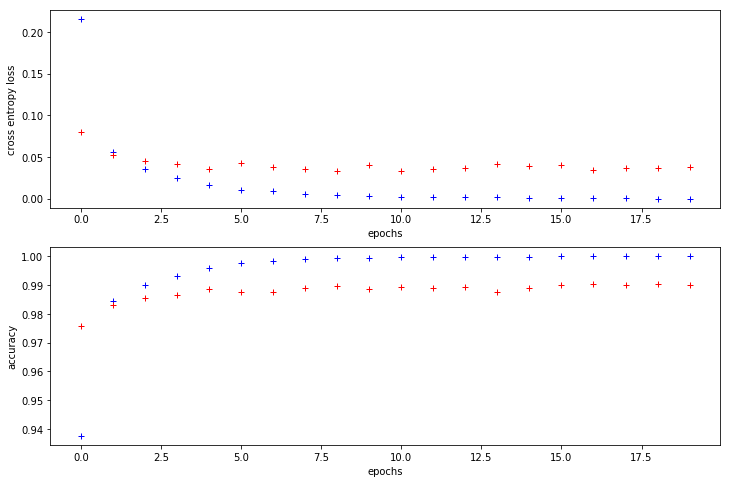

[{'parameters': {'conv_1_kernel_size': 5, 'conv_1_filters': 32}, 'best_summary': {'epoch': 13, 'batch': 106, 'train_loss': 0.0008638494, 'train_accuracy': 0.999927, 'test_loss': 0.035978954, 'test_accuracy': 0.9914}}, {'parameters': {'conv_1_kernel_size': 3, 'conv_1_filters': 32}, 'best_summary': {'epoch': 10, 'batch': 106, 'train_loss': 0.0003465565, 'train_accuracy': 1.0, 'test_loss': 0.038362384, 'test_accuracy': 0.9902}}, {'parameters': {'conv_1_kernel_size': 5, 'conv_1_filters': 16}, 'best_summary': {'epoch': 16, 'batch': 106, 'train_loss': 0.00038379122, 'train_accuracy': 0.99998176, 'test_loss': 0.03478903, 'test_accuracy': 0.9902}}, {'parameters': {'conv_1_kernel_size': 5, 'conv_1_filters': 8}, 'best_summary': {'epoch': 14, 'batch': 106, 'train_loss': 0.0024778459, 'train_accuracy': 0.9997262, 'test_loss': 0.039582472, 'test_accuracy': 0.9893}}, {'parameters': {'conv_1_kernel_size': 3, 'conv_1_filters': 16}, 'best_summary': {'epoch': 15, 'batch': 106, 'train_loss': 0.0003391532

In [22]:
# CNN [3,5]x[3,5]x[2,4,8,16,32] -> Relu -> Dense -> Output Layer -> Softmax -> Y
# Architecture: X -> Output Layer -> Argmax -> Y
# Grid search over kernel_size, filters
# Goal: find optimal hyper parameters for shallow network

parameter_combinations = []
for conv_1_kernel_size in [3,5]:
    for conv_1_filters in [32,4,8,16]:
        parameters = {
            'conv_1_kernel_size': conv_1_kernel_size,
            'conv_1_filters': conv_1_filters,
        }
        parameter_combinations.append(parameters)
results = []
for parameters in parameter_combinations:
    print('parameters: ', parameters)
    tf.reset_default_graph()
    tf.set_random_seed(0)
    X = tf.placeholder(tf.float32, shape=[None, n_X])            
    # reshapes [n_batch,784] -> [n_batch,28,28,1] for CNN consumption
    input_layer = tf.reshape(X, [-1, image_height, image_width, 1])
    conv_1_layer = tf.layers.conv2d(
        inputs=input_layer,
        filters=parameters['conv_1_filters'],
        kernel_size=[parameters['conv_1_kernel_size'], parameters['conv_1_kernel_size']],
        padding="same",
        activation=tf.nn.relu)
    maxpool_1_layer = tf.layers.max_pooling2d(inputs=conv_1_layer, pool_size=[2, 2], strides=2)
    maxpool_1_layer_reshaped = tf.reshape(maxpool_1_layer, [-1, 14 * 14 * parameters['conv_1_filters']])
    hidden_1_layer = tf.layers.dense(inputs=maxpool_1_layer_reshaped, units=14 * 14 * parameters['conv_1_filters'], activation=tf.nn.relu)
    output_layer = tf.layers.dense(inputs=hidden_1_layer, units=n_Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    summaries = train(output_layer, optimizer, epochs=20, batch_size=512, print_progress=True)['summaries']
    plot_summaries(summaries)
    best_summary = sorted(summaries, key=lambda x: x['test_accuracy'], reverse=True)[0] 
    results.append({
        'parameters': parameters,
        'best_summary': best_summary
    })

sorted_results = sorted(results, key=lambda x: x['best_summary']['test_accuracy'], reverse=True)  
print(sorted_results)
                                                                                                                             

In [27]:

print("best results")
for result in sorted_results:
    template = "test acc: {test_accuracy:5.4f} epoch:{epoch:2d} loss_diff: {loss_diff:4.3f} conv_1_kernel_size: {conv_1_kernel_size:3d} conv_1_filters: {conv_1_filters:3d}"
    print(template.format(test_accuracy=result['best_summary']['test_accuracy'], 
                          conv_1_kernel_size=result['parameters']['conv_1_kernel_size'],
                          conv_1_filters=result['parameters']['conv_1_filters'], 
                          epoch=result['best_summary']['epoch'],
                          loss_diff=result['best_summary']['test_loss'] - result['best_summary']['train_loss']))




best results
test acc: 0.9914 epoch:13 loss_diff: 0.035 conv_1_kernel_size:   5 conv_1_filters:  32
test acc: 0.9902 epoch:10 loss_diff: 0.038 conv_1_kernel_size:   3 conv_1_filters:  32
test acc: 0.9902 epoch:16 loss_diff: 0.034 conv_1_kernel_size:   5 conv_1_filters:  16
test acc: 0.9893 epoch:14 loss_diff: 0.037 conv_1_kernel_size:   5 conv_1_filters:   8
test acc: 0.9886 epoch:15 loss_diff: 0.045 conv_1_kernel_size:   3 conv_1_filters:  16
test acc: 0.9878 epoch:13 loss_diff: 0.033 conv_1_kernel_size:   5 conv_1_filters:   4
test acc: 0.9873 epoch:13 loss_diff: 0.042 conv_1_kernel_size:   3 conv_1_filters:   8
test acc: 0.9855 epoch:19 loss_diff: 0.045 conv_1_kernel_size:   3 conv_1_filters:   4
